# HDRL Phase 3 - Global Coordinator with Hierarchical Deep Reinforcement Learning

## AWS Multi-Region Deployment (us-east-1 + eu-west-1)

**Architecture:**
- Global Coordinator: High-level task allocation using Actor-Critic
- Local PPO Agents: Pre-trained from Phase 2 (AWS-US-EAST-1 + AWS-EU-WEST-1)
- Task Segmentation: K-means clustering for complexity-based allocation
- Privacy: Differential Privacy for inter-agent communication

**Version:** 1.0
**Date:** November 2025
**Status:** Phase 3 - Hierarchical Coordination

In [1]:
# Standard library imports
import os
import sys
import json
import pickle
import random
import warnings
from collections import deque
from datetime import datetime
from typing import Dict, List, Tuple, Optional

# Suppress warnings
warnings.filterwarnings('ignore')

# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

print("✅ Standard imports complete")

✅ Standard imports complete


In [2]:
# ML/RL framework imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

tf.random.set_seed(GLOBAL_SEED)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ NumPy version: {np.__version__}")
print(f"✅ Pandas version: {pd.__version__}")

✅ TensorFlow version: 2.19.0
✅ NumPy version: 2.0.2
✅ Pandas version: 2.2.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/mythesis/srilakshmi/HDRL_Research'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_PATH = os.path.join(BASE_PATH, 'models')
RESULTS_PATH = os.path.join(BASE_PATH, 'results')

os.makedirs(os.path.join(MODEL_PATH, 'global_coordinator'), exist_ok=True)
os.makedirs(os.path.join(RESULTS_PATH, 'phase3_aws'), exist_ok=True)

print(f"✅ Base path: {BASE_PATH}")
print(f"✅ Directories verified")

Mounted at /content/drive
✅ Base path: /content/drive/MyDrive/mythesis/srilakshmi/HDRL_Research
✅ Directories verified


In [4]:
# Load data
train_df = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'train_tasks.csv'))
val_df = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'val_tasks.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'test_tasks.csv'))

print(f"✅ Training data loaded: {len(train_df)} tasks")
print(f"✅ Validation data loaded: {len(val_df)} tasks")
print(f"✅ Test data loaded: {len(test_df)} tasks")

✅ Training data loaded: 284123 tasks
✅ Validation data loaded: 40589 tasks
✅ Test data loaded: 81179 tasks


## 1. Load Phase 2 Components

In [7]:
class TaskSegmentationModule:
    def __init__(self, n_segments=5):
        self.n_segments = n_segments
        self.kmeans = KMeans(n_clusters=n_segments, random_state=42)
        self.scaler = StandardScaler()
        self.is_fitted = False

    def extract_task_features(self, tasks_df):
        features = ['cpu_request', 'memory_request', 'data_size',
                   'priority', 'duration', 'resource_intensity']
        available_features = [f for f in features if f in tasks_df.columns]
        return tasks_df[available_features].values

    def fit(self, tasks_df):
        features = self.extract_task_features(tasks_df)
        features_scaled = self.scaler.fit_transform(features)
        self.kmeans.fit(features_scaled)
        self.is_fitted = True
        return self

    def predict_segment(self, task_dict):
        if not self.is_fitted:
            return 0
        features = np.array([[
            task_dict.get('cpu_request', 0.5),
            task_dict.get('memory_request', 1.0),
            task_dict.get('data_size', 0.1),
            task_dict.get('priority', 0),
            task_dict.get('duration', 60),
            task_dict.get('resource_intensity', 0.5)
        ]])
        features_scaled = self.scaler.transform(features)
        return self.kmeans.predict(features_scaled)[0]

    def calculate_complexity_score(self, task_dict):
        cpu = task_dict.get('cpu_request', 0.5)
        mem = task_dict.get('memory_request', 1.0)
        duration = task_dict.get('duration', 60)
        return (cpu * mem * duration) / 1000.0

task_segmenter = TaskSegmentationModule(n_segments=5)
print("✅ Task segmentation module initialized")

✅ Task segmentation module initialized


In [8]:
# Load Task Segmentation Module from Phase 2
with open(os.path.join(MODEL_PATH, 'task_segmenter_v3.pkl'), 'rb') as f:
    task_segmenter = pickle.load(f)

print(f"✅ Task segmenter loaded: {task_segmenter.n_segments} segments")

✅ Task segmenter loaded: 5 segments


In [9]:
# Load Differential Privacy Configuration
with open(os.path.join(MODEL_PATH, 'dp_layer_config_v3.json'), 'r') as f:
    dp_config = json.load(f)

print(f"✅ DP config loaded: ε={dp_config['epsilon']}, δ={dp_config['delta']}")

✅ DP config loaded: ε=1.0, δ=1e-05


In [10]:
# Load Phase 2 training history
with open(os.path.join(RESULTS_PATH, 'phase2_v3_aws/training_history.pkl'), 'rb') as f:
    phase2_history = pickle.load(f)

print("✅ Phase 2 training history loaded:")
for region in phase2_history.keys():
    avg_reward = np.mean(phase2_history[region]['episode_rewards'][-10:])
    print(f"  {region}: Final avg reward = {avg_reward:.2f}")

✅ Phase 2 training history loaded:
  AWS-US-EAST-1: Final avg reward = -705.36
  AWS-EU-WEST-1: Final avg reward = -708.27


## 2. Cloud Provider Configuration (Same as Phase 2)

In [11]:
class CloudProviderConfig:
    """AWS cloud provider configuration"""

    def __init__(self, name, region, cpu_capacity, memory_capacity, storage_capacity,
                 cost_per_cpu_hour, cost_per_gb_hour, energy_per_cpu_hour,
                 energy_per_gb_hour, base_latency, pricing_model):
        self.name = name
        self.region = region
        self.cpu_capacity = cpu_capacity
        self.memory_capacity = memory_capacity
        self.storage_capacity = storage_capacity
        self.cost_per_cpu_hour = cost_per_cpu_hour
        self.cost_per_gb_hour = cost_per_gb_hour
        self.energy_per_cpu_hour = energy_per_cpu_hour
        self.energy_per_gb_hour = energy_per_gb_hour
        self.base_latency = base_latency
        self.pricing_model = pricing_model
        self.current_cpu_used = 0
        self.current_memory_used = 0
        self.current_storage_used = 0

    def get_available_resources(self):
        return {
            'cpu_available': self.cpu_capacity - self.current_cpu_used,
            'memory_available': self.memory_capacity - self.current_memory_used,
            'storage_available': self.storage_capacity - self.current_storage_used
        }

    def allocate_resources(self, cpu, memory, storage):
        self.current_cpu_used += cpu
        self.current_memory_used += memory
        self.current_storage_used += storage

    def release_resources(self, cpu, memory, storage):
        self.current_cpu_used = max(0, self.current_cpu_used - cpu)
        self.current_memory_used = max(0, self.current_memory_used - memory)
        self.current_storage_used = max(0, self.current_storage_used - storage)

    def reset(self):
        self.current_cpu_used = 0
        self.current_memory_used = 0
        self.current_storage_used = 0

# Initialize TWO AWS providers
providers = {
    'AWS-US-EAST-1': CloudProviderConfig(
        name='AWS-US-EAST-1',
        region='us-east-1',
        cpu_capacity=1000,
        memory_capacity=4000,
        storage_capacity=10000,
        cost_per_cpu_hour=0.05,
        cost_per_gb_hour=0.01,
        energy_per_cpu_hour=2.5,
        energy_per_gb_hour=0.5,
        base_latency=10,
        pricing_model='On-Demand'
    ),
    'AWS-EU-WEST-1': CloudProviderConfig(
        name='AWS-EU-WEST-1',
        region='eu-west-1',
        cpu_capacity=1000,
        memory_capacity=4000,
        storage_capacity=10000,
        cost_per_cpu_hour=0.015,
        cost_per_gb_hour=0.003,
        energy_per_cpu_hour=2.3,
        energy_per_gb_hour=0.48,
        base_latency=90,
        pricing_model='Spot'
    )
}

print("✅ AWS providers configured (2 regions)")

✅ AWS providers configured (2 regions)


## 3. Differential Privacy Layer (Enhanced for Communication)

In [12]:
class DifferentialPrivacyLayer:
    def __init__(self, epsilon=1.0, delta=1e-5, sensitivity=1.0):
        self.epsilon = epsilon
        self.delta = delta
        self.sensitivity = sensitivity
        self.noise_scale = self._calculate_noise_scale()
        self.privacy_budget_used = 0.0
        self.communication_count = 0

    def _calculate_noise_scale(self):
        import math
        sigma = math.sqrt(2 * math.log(1.25 / self.delta)) * self.sensitivity / self.epsilon
        return sigma

    def add_noise(self, data, sensitivity=None):
        if sensitivity is None:
            sensitivity = self.sensitivity
        noise_scale = self.noise_scale * sensitivity
        noise = np.random.normal(0, noise_scale, size=data.shape)
        self.privacy_budget_used += self.epsilon
        self.communication_count += 1
        return (data + noise).astype(np.float32)

    def get_privacy_budget(self):
        return {
            'epsilon': self.epsilon,
            'delta': self.delta,
            'budget_used': self.privacy_budget_used,
            'communications': self.communication_count
        }

    def reset_budget(self):
        self.privacy_budget_used = 0.0
        self.communication_count = 0

dp_layer = DifferentialPrivacyLayer(
    epsilon=dp_config['epsilon'],
    delta=dp_config['delta'],
    sensitivity=1.0
)

print(f"✅ DP layer initialized: ε={dp_layer.epsilon}, δ={dp_layer.delta}")

✅ DP layer initialized: ε=1.0, δ=1e-05


## 4. Multi-Cloud Environment (Reuse from Phase 2)

In [13]:
class MultiCloudEnvironment:
    def __init__(self, provider, max_steps=200, time_step=60):
        self.provider = provider
        self.max_steps = max_steps
        self.time_step = time_step
        self.current_step = 0
        self.current_time = 0
        self.task_queue = deque()
        self.running_tasks = []
        self.completed_tasks = []
        self.failed_tasks = []
        self.total_cost = 0
        self.total_energy = 0
        self.total_waiting_time = 0

    def reset(self):
        self.current_step = 0
        self.current_time = 0
        self.task_queue.clear()
        self.running_tasks.clear()
        self.completed_tasks.clear()
        self.failed_tasks.clear()
        self.total_cost = 0
        self.total_energy = 0
        self.total_waiting_time = 0
        self.provider.reset()
        return self._get_state()

    def add_task(self, task):
        self.task_queue.append(task)

    def _process_completed_tasks(self):
        completed = []
        for task_info in self.running_tasks:
            if task_info['completion_time'] <= self.current_time:
                self.provider.release_resources(
                    task_info['cpu'], task_info['mem'], task_info['storage']
                )
                self.completed_tasks.append(task_info['task'])
                completed.append(task_info)

        for task_info in completed:
            self.running_tasks.remove(task_info)

        return len(completed)

    def step(self, action):
        self.current_time += self.time_step
        self.current_step += 1

        num_completed = self._process_completed_tasks()
        done = self.current_step >= self.max_steps

        if len(self.task_queue) == 0:
            return self._get_state(), -1, done, {'num_completed': num_completed}

        max_selection = min(50, len(self.task_queue))
        task_idx = min(action, max_selection - 1)
        task_list = list(self.task_queue)
        selected_task = task_list[task_idx]
        self.task_queue.remove(selected_task)

        cpu_req = selected_task.get('cpu_request', 0.5)
        mem_req = selected_task.get('memory_request', 1.0)
        storage_req = selected_task.get('data_size', 0.1)
        duration = selected_task.get('duration', 60)
        arrival_time = selected_task.get('timestamp', 0)

        waiting_time = max(0, self.current_time - arrival_time)
        self.total_waiting_time += waiting_time

        resources = self.provider.get_available_resources()

        if (cpu_req <= resources['cpu_available'] and
            mem_req <= resources['memory_available']):

            self.provider.allocate_resources(cpu_req, mem_req, storage_req)

            cost = (cpu_req * self.provider.cost_per_cpu_hour * duration / 3600 +
                   mem_req * self.provider.cost_per_gb_hour * duration / 3600)
            self.total_cost += cost

            energy = (cpu_req * self.provider.energy_per_cpu_hour * duration / 3600 +
                     mem_req * self.provider.energy_per_gb_hour * duration / 3600)
            self.total_energy += energy

            latency = self.provider.base_latency + (duration / 1000.0)

            completion_time = self.current_time + duration
            self.running_tasks.append({
                'task': selected_task,
                'completion_time': completion_time,
                'cpu': cpu_req,
                'mem': mem_req,
                'storage': storage_req
            })

            reward = self._calculate_reward(
                cpu=cpu_req, mem=mem_req, cost=cost, energy=energy,
                latency=latency, duration=duration,
                waiting_time=waiting_time, success=True
            )

            info = {
                'success': True, 'cost': cost, 'energy': energy,
                'latency': latency, 'waiting_time': waiting_time,
                'num_completed': num_completed,
                'queue_length': len(self.task_queue),
                'num_running': len(self.running_tasks),
                'task_idx': task_idx
            }
        else:
            self.failed_tasks.append(selected_task)
            reward = -10
            info = {
                'success': False, 'num_completed': num_completed,
                'queue_length': len(self.task_queue),
                'num_running': len(self.running_tasks),
                'task_idx': task_idx
            }

        return self._get_state(), reward, done, info

    def _calculate_reward(self, cpu, mem, cost, energy, latency, duration, waiting_time, success):
        if not success:
            return -10

        cpu_util = self.provider.current_cpu_used / self.provider.cpu_capacity
        mem_util = self.provider.current_memory_used / self.provider.memory_capacity
        avg_util = (cpu_util + mem_util) / 2

        if 0.6 <= avg_util <= 0.8:
            utilization_reward = 10
        elif avg_util > 0.8:
            utilization_reward = 10 - (avg_util - 0.8) * 30
        else:
            utilization_reward = avg_util * 12

        queue_length = len(self.task_queue)
        if queue_length < 10:
            queue_reward = 5
        elif queue_length < 30:
            queue_reward = 2
        else:
            queue_reward = -(queue_length - 30) * 0.2

        max_acceptable_wait = 300
        waiting_penalty = -(waiting_time - max_acceptable_wait) * 0.01 if waiting_time > max_acceptable_wait else 0

        task_size = cpu * mem * duration
        cost_efficiency = -cost / (task_size + 1e-6) * 5

        energy_penalty = -energy * 0.05
        completion_bonus = 3

        reward = (
            0.30 * utilization_reward +
            0.20 * queue_reward +
            0.15 * waiting_penalty +
            0.15 * cost_efficiency +
            0.10 * energy_penalty +
            0.10 * completion_bonus
        )

        return reward

    def _get_state(self):
        resources = self.provider.get_available_resources()
        cpu_avail = resources['cpu_available'] / self.provider.cpu_capacity
        mem_avail = resources['memory_available'] / self.provider.memory_capacity
        cpu_util = self.provider.current_cpu_used / self.provider.cpu_capacity
        mem_util = self.provider.current_memory_used / self.provider.memory_capacity

        queue_length_norm = min(len(self.task_queue) / 100.0, 1.0)
        num_running_norm = min(len(self.running_tasks) / 50.0, 1.0)

        if len(self.task_queue) > 0:
            queue_tasks = list(self.task_queue)[:10]
            avg_queue_cpu = np.mean([t.get('cpu_request', 0.5) for t in queue_tasks])
            avg_queue_mem = np.mean([t.get('memory_request', 1.0) for t in queue_tasks])
            avg_queue_priority = np.mean([t.get('priority', 0) for t in queue_tasks])
        else:
            avg_queue_cpu = avg_queue_mem = avg_queue_priority = 0

        cost_norm = self.provider.cost_per_cpu_hour / 0.5
        energy_norm = self.provider.energy_per_cpu_hour / 5.0
        latency_norm = self.provider.base_latency / 200.0

        step_progress = self.current_step / self.max_steps
        completion_rate = len(self.completed_tasks) / max(self.current_step, 1)
        failure_rate = len(self.failed_tasks) / max(self.current_step, 1)
        cost_so_far_norm = min(self.total_cost / 1000.0, 1.0)

        state = np.array([
            cpu_avail, mem_avail, cpu_util, mem_util,
            queue_length_norm, num_running_norm,
            avg_queue_cpu, avg_queue_mem, avg_queue_priority,
            cost_norm, energy_norm, latency_norm,
            step_progress, completion_rate, failure_rate, cost_so_far_norm,
            0.0, 0.0, 0.0, 0.0
        ], dtype=np.float32)

        return state

print("✅ MultiCloudEnvironment defined")

✅ MultiCloudEnvironment defined


## 5. Local PPO Agents (Load Pre-trained from Phase 2)

In [14]:
STATE_DIM = 20
ACTION_DIM = 50

class PPOActorCritic(tf.keras.Model):
    def __init__(self, state_dim, action_dim, hidden_units=[256, 128]):
        super(PPOActorCritic, self).__init__()
        self.dense1 = layers.Dense(hidden_units[0], activation='relu')
        self.dense2 = layers.Dense(hidden_units[1], activation='relu')
        self.dropout = layers.Dropout(0.2)
        self.actor = layers.Dense(action_dim)
        self.critic = layers.Dense(1)

    def call(self, state, training=False):
        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dropout(x, training=training)
        return self.actor(x), self.critic(x)

    def get_action(self, state, training=True):
        if len(state.shape) == 1:
            state = tf.expand_dims(state, 0)
        action_logits, value = self(state, training=training)
        dist = tfp.distributions.Categorical(logits=action_logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.numpy()[0], log_prob.numpy()[0], value.numpy()[0][0]

print("✅ PPO Actor-Critic class defined")

✅ PPO Actor-Critic class defined


In [15]:
# Load pre-trained local agents from Phase 2
local_agents = {}
environments = {}

for provider_name, provider_config in providers.items():
    # Create agent
    agent = PPOActorCritic(state_dim=STATE_DIM, action_dim=ACTION_DIM)

    # Initialize with dummy forward pass
    dummy_state = tf.random.normal((1, STATE_DIM))
    _ = agent(dummy_state)

    # Load weights from Phase 2
    weights_path = os.path.join(MODEL_PATH, f'ppo_agents_v3_aws/{provider_name}_final.weights.h5')
    agent.load_weights(weights_path)

    local_agents[provider_name] = agent

    # Create environment
    env = MultiCloudEnvironment(provider_config, max_steps=200, time_step=60)
    environments[provider_name] = env

    print(f"✅ {provider_name}: Pre-trained agent loaded")

print(f"\n✅ Total local agents: {len(local_agents)}")

✅ AWS-US-EAST-1: Pre-trained agent loaded
✅ AWS-EU-WEST-1: Pre-trained agent loaded

✅ Total local agents: 2


## 6. Global Coordinator Network

In [16]:
# Global Coordinator input: aggregated states from 2 local agents
# Each local state: 20-dim → Total: 40-dim
# Plus task features: 6-dim (cpu, mem, duration, priority, complexity, segment)
GLOBAL_STATE_DIM = 40 + 6

# Global Coordinator action: allocate task to region 0 or 1
GLOBAL_ACTION_DIM = 2  # Binary decision: US-EAST-1 or EU-WEST-1

class GlobalCoordinator(tf.keras.Model):
    """Global Coordinator using Actor-Critic for high-level task allocation"""

    def __init__(self, state_dim, action_dim, hidden_units=[256, 128, 64]):
        super(GlobalCoordinator, self).__init__()
        self.dense1 = layers.Dense(hidden_units[0], activation='relu')
        self.dense2 = layers.Dense(hidden_units[1], activation='relu')
        self.dense3 = layers.Dense(hidden_units[2], activation='relu')
        self.dropout1 = layers.Dropout(0.2)
        self.dropout2 = layers.Dropout(0.2)

        # Actor: outputs region allocation probabilities
        self.actor = layers.Dense(action_dim)

        # Critic: estimates value of current global state
        self.critic = layers.Dense(1)

    def call(self, state, training=False):
        x = self.dense1(state)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
        x = self.dense3(x)
        return self.actor(x), self.critic(x)

    def get_action(self, state, training=True):
        """Select which region to allocate task to"""
        if len(state.shape) == 1:
            state = tf.expand_dims(state, 0)
        action_logits, value = self(state, training=training)
        dist = tfp.distributions.Categorical(logits=action_logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.numpy()[0], log_prob.numpy()[0], value.numpy()[0][0]

    def evaluate(self, states, actions):
        action_logits, values = self(states)
        dist = tfp.distributions.Categorical(logits=action_logits)
        return dist.log_prob(actions), values, dist.entropy()

# Initialize Global Coordinator
global_coordinator = GlobalCoordinator(
    state_dim=GLOBAL_STATE_DIM,
    action_dim=GLOBAL_ACTION_DIM,
    hidden_units=[256, 128, 64]
)

print(f"✅ Global Coordinator initialized:")
print(f"   Input: {GLOBAL_STATE_DIM}-dim (2 agents × 20-dim + 6-dim task features)")
print(f"   Output: {GLOBAL_ACTION_DIM} regions (US-EAST-1 or EU-WEST-1)")

✅ Global Coordinator initialized:
   Input: 46-dim (2 agents × 20-dim + 6-dim task features)
   Output: 2 regions (US-EAST-1 or EU-WEST-1)


## 7. Global Coordinator Trainer (PPO)

In [17]:
class GlobalCoordinatorTrainer:
    """PPO trainer for Global Coordinator"""

    def __init__(self, model, learning_rate=3e-4, gamma=0.99, lam=0.95,
                 clip_ratio=0.2, value_coef=0.5, entropy_coef=0.01):
        self.model = model
        self.optimizer = Adam(learning_rate=learning_rate)
        self.gamma = gamma
        self.lam = lam
        self.clip_ratio = clip_ratio
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.last_policy_loss = 0
        self.last_value_loss = 0

    def compute_gae(self, rewards, values, dones):
        advantages = []
        gae = 0
        for t in reversed(range(len(rewards))):
            next_value = 0 if t == len(rewards) - 1 else values[t + 1]
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        returns = [adv + val for adv, val in zip(advantages, values)]
        return np.array(advantages, dtype=np.float32), np.array(returns, dtype=np.float32)

    @tf.function
    def train_step(self, states, actions, old_log_probs, advantages, returns):
        with tf.GradientTape() as tape:
            log_probs, values, entropy = self.model.evaluate(states, actions)
            values = tf.squeeze(values)
            ratio = tf.exp(log_probs - old_log_probs)
            clipped_ratio = tf.clip_by_value(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio)
            policy_loss = -tf.reduce_mean(tf.minimum(
                ratio * advantages, clipped_ratio * advantages
            ))
            value_loss = tf.reduce_mean(tf.square(returns - values))
            entropy_loss = -tf.reduce_mean(entropy)
            total_loss = policy_loss + self.value_coef * value_loss + self.entropy_coef * entropy_loss
        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return policy_loss, value_loss, entropy_loss

    def update(self, trajectory, epochs=10, batch_size=64):
        states = np.array(trajectory['states'])
        actions = np.array(trajectory['actions'])
        old_log_probs = np.array(trajectory['log_probs'])
        rewards = np.array(trajectory['rewards'])
        values = np.array(trajectory['values'])
        dones = np.array(trajectory['dones'])

        advantages, returns = self.compute_gae(rewards, values, dones)
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

        states = tf.constant(states, dtype=tf.float32)
        actions = tf.constant(actions, dtype=tf.int32)
        old_log_probs = tf.constant(old_log_probs, dtype=tf.float32)
        advantages = tf.constant(advantages, dtype=tf.float32)
        returns = tf.constant(returns, dtype=tf.float32)

        dataset_size = len(states)
        indices = np.arange(dataset_size)

        for epoch in range(epochs):
            np.random.shuffle(indices)
            for start in range(0, dataset_size, batch_size):
                end = min(start + batch_size, dataset_size)
                batch_indices = indices[start:end]
                policy_loss, value_loss, _ = self.train_step(
                    tf.gather(states, batch_indices),
                    tf.gather(actions, batch_indices),
                    tf.gather(old_log_probs, batch_indices),
                    tf.gather(advantages, batch_indices),
                    tf.gather(returns, batch_indices)
                )

        self.last_policy_loss = policy_loss.numpy()
        self.last_value_loss = value_loss.numpy()

gc_trainer = GlobalCoordinatorTrainer(global_coordinator, learning_rate=3e-4)
print("✅ Global Coordinator Trainer initialized")

✅ Global Coordinator Trainer initialized


## 8. Hierarchical Communication Protocol

In [18]:
def aggregate_local_states(environments, dp_layer):
    """
    Aggregate states from all local agents with differential privacy.
    Returns: (40-dim) concatenated state vector
    """
    states = []
    region_names = list(environments.keys())

    for region_name in region_names:
        env = environments[region_name]
        local_state = env._get_state()  # 20-dim

        # Apply differential privacy to state before sending to Global Coordinator
        privatized_state = dp_layer.add_noise(local_state, sensitivity=0.1)
        states.append(privatized_state)

    # Concatenate states from all regions
    aggregated_state = np.concatenate(states)  # 40-dim for 2 regions
    return aggregated_state, region_names

def extract_task_features(task, task_segmenter):
    """
    Extract features from a task for Global Coordinator.
    Returns: (6-dim) task feature vector
    """
    cpu = task.get('cpu_request', 0.5)
    mem = task.get('memory_request', 1.0)
    duration = task.get('duration', 60)
    priority = task.get('priority', 0)

    # Calculate complexity using task segmenter
    complexity = task_segmenter.calculate_complexity_score(task)
    segment = task_segmenter.predict_segment(task)

    # Normalize features
    task_features = np.array([
        cpu / 10.0,  # Normalize
        mem / 20.0,
        duration / 3600.0,
        priority / 10.0,
        complexity,
        segment / 5.0
    ], dtype=np.float32)

    return task_features

def create_global_state(aggregated_local_states, task_features):
    """
    Create global state for Global Coordinator.
    Returns: (46-dim) state = 40-dim (local states) + 6-dim (task features)
    """
    global_state = np.concatenate([aggregated_local_states, task_features])
    return global_state

print("✅ Hierarchical communication protocol defined")

✅ Hierarchical communication protocol defined


## 9. Workload Generation (Same as Phase 2)

In [19]:
def generate_synthetic_workload(n_tasks, base_data, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    samples = base_data.sample(n=n_tasks, replace=True if len(base_data) < n_tasks else False, random_state=random_seed)
    workload = []
    for idx, row in samples.iterrows():
        task = {
            'task_id': f'task_{idx}_{random_seed if random_seed else 0}',
            'timestamp': row.get('timestamp', 0) + np.random.uniform(-3600, 3600),
            'cpu_request': max(0.1, row.get('cpu_request', 0.5) * np.random.uniform(0.8, 1.2)),
            'memory_request': max(0.1, row.get('memory_request', 1.0) * np.random.uniform(0.8, 1.2)),
            'duration': max(10, row.get('duration', 60) * np.random.uniform(0.7, 1.3)),
            'priority': row.get('priority', 0),
            'data_size': max(0.01, row.get('data_size', 0.1) * np.random.uniform(0.9, 1.1)),
            'task_type': row.get('task_type', 0),
            'has_dependency': row.get('has_dependency', 0),
            'resource_intensity': row.get('resource_intensity', 0.5)
        }
        workload.append(task)
    return workload

print("✅ Workload generation function defined")

✅ Workload generation function defined


## 10. Phase 3 Hierarchical Training Loop

In [20]:
NUM_EPISODES = 50
MAX_STEPS_PER_EPISODE = 200
NUM_TASKS = 5000
SAVE_INTERVAL = 10

# Training history
training_history = {
    'global': {
        'episode_rewards': [],
        'total_costs': [],
        'total_energy': [],
        'privacy_budget_used': [],
        'region_allocations': []  # Track which regions were selected
    }
}

for provider_name in providers.keys():
    training_history[provider_name] = {
        'episode_rewards': [],
        'episode_costs': [],
        'completed_tasks': [],
        'failed_tasks': []
    }

print("="*60)
print(f"STARTING PHASE 3 HIERARCHICAL TRAINING - {NUM_EPISODES} EPISODES")
print("="*60)
print(f"Regions: {list(providers.keys())}")
print(f"Global Coordinator: {GLOBAL_STATE_DIM}-dim input, {GLOBAL_ACTION_DIM} actions")
print("="*60)

STARTING PHASE 3 HIERARCHICAL TRAINING - 50 EPISODES
Regions: ['AWS-US-EAST-1', 'AWS-EU-WEST-1']
Global Coordinator: 46-dim input, 2 actions


In [21]:
for episode in range(NUM_EPISODES):
    print(f"\nEPISODE {episode + 1}/{NUM_EPISODES}")

    # Generate workload
    workload = generate_synthetic_workload(
        n_tasks=NUM_TASKS,
        base_data=train_df.sample(min(1000, len(train_df)), random_state=episode),
        random_seed=episode
    )

    # Reset all environments
    for env in environments.values():
        env.reset()

    # Reset DP budget for this episode
    dp_layer.reset_budget()

    # Global Coordinator trajectory
    gc_trajectory = {
        'states': [],
        'actions': [],
        'log_probs': [],
        'rewards': [],
        'values': [],
        'dones': []
    }

    episode_total_cost = 0
    episode_total_energy = 0
    episode_gc_reward = 0
    region_allocation_counts = {name: 0 for name in providers.keys()}
    region_names = list(providers.keys())

    # Process tasks one by one through Global Coordinator
    for step, task in enumerate(workload[:MAX_STEPS_PER_EPISODE]):
        # 1. Aggregate states from local agents (with DP)
        aggregated_states, _ = aggregate_local_states(environments, dp_layer)

        # 2. Extract task features
        task_features = extract_task_features(task, task_segmenter)

        # 3. Create global state
        global_state = create_global_state(aggregated_states, task_features)

        # 4. Global Coordinator selects region
        region_action, log_prob, value = global_coordinator.get_action(global_state, training=True)
        selected_region = region_names[region_action]
        region_allocation_counts[selected_region] += 1

        # 5. Add task to selected region's environment
        selected_env = environments[selected_region]
        selected_env.add_task(task)

        # 6. Local agent executes task
        local_agent = local_agents[selected_region]
        local_state = selected_env._get_state()
        privatized_local_state = dp_layer.add_noise(local_state, sensitivity=0.1)
        local_action, _, _ = local_agent.get_action(privatized_local_state, training=False)  # Use pre-trained weights

        # 7. Environment step
        next_state, local_reward, done, info = selected_env.step(local_action)

        # 8. Calculate global reward (sum of rewards from both regions)
        global_reward = local_reward

        # Add cost/energy efficiency bonus to global reward
        if info.get('success', False):
            cost = info['cost']
            energy = info['energy']
            episode_total_cost += cost
            episode_total_energy += energy

            # Bonus for choosing cheaper region (EU-WEST-1)
            if selected_region == 'AWS-EU-WEST-1':
                global_reward += 2  # Bonus for using spot instances

        episode_gc_reward += global_reward

        # 9. Store trajectory
        gc_trajectory['states'].append(global_state)
        gc_trajectory['actions'].append(region_action)
        gc_trajectory['log_probs'].append(log_prob)
        gc_trajectory['rewards'].append(global_reward)
        gc_trajectory['values'].append(value)
        gc_trajectory['dones'].append(done)

        if done or step >= MAX_STEPS_PER_EPISODE - 1:
            break

    # 10. Update Global Coordinator
    if len(gc_trajectory['states']) >= 32:
        gc_trainer.update(gc_trajectory, epochs=10, batch_size=64)

    # 11. Record episode metrics
    training_history['global']['episode_rewards'].append(episode_gc_reward)
    training_history['global']['total_costs'].append(episode_total_cost)
    training_history['global']['total_energy'].append(episode_total_energy)
    training_history['global']['privacy_budget_used'].append(dp_layer.privacy_budget_used)
    training_history['global']['region_allocations'].append(region_allocation_counts)

    for region_name, env in environments.items():
        training_history[region_name]['episode_costs'].append(env.total_cost)
        training_history[region_name]['completed_tasks'].append(len(env.completed_tasks))
        training_history[region_name]['failed_tasks'].append(len(env.failed_tasks))

    # 12. Print episode summary
    print(f"  Global Reward: {episode_gc_reward:.2f}")
    print(f"  Total Cost: ${episode_total_cost:.2f}")
    print(f"  Privacy Budget Used: ε={dp_layer.privacy_budget_used:.2f}")
    print(f"  Region Allocation: US-EAST={region_allocation_counts['AWS-US-EAST-1']}, EU-WEST={region_allocation_counts['AWS-EU-WEST-1']}")
    for region_name, env in environments.items():
        print(f"  [{region_name}] Completed: {len(env.completed_tasks)}, Failed: {len(env.failed_tasks)}, Cost: ${env.total_cost:.2f}")

    # 13. Save checkpoints
    if (episode + 1) % SAVE_INTERVAL == 0:
        global_coordinator.save_weights(
            os.path.join(MODEL_PATH, f'global_coordinator/gc_ep{episode + 1}.weights.h5')
        )

print("\n" + "="*60)
print("PHASE 3 HIERARCHICAL TRAINING COMPLETE!")
print("="*60)


EPISODE 1/50
  Global Reward: 258.44
  Total Cost: $16.79
  Privacy Budget Used: ε=600.00
  Region Allocation: US-EAST=131, EU-WEST=69
  [AWS-US-EAST-1] Completed: 15, Failed: 0, Cost: $14.53
  [AWS-EU-WEST-1] Completed: 0, Failed: 0, Cost: $2.25

EPISODE 2/50
  Global Reward: 114.15
  Total Cost: $21.29
  Privacy Budget Used: ε=600.00
  Region Allocation: US-EAST=188, EU-WEST=12
  [AWS-US-EAST-1] Completed: 71, Failed: 0, Cost: $20.85
  [AWS-EU-WEST-1] Completed: 0, Failed: 0, Cost: $0.44

EPISODE 3/50
  Global Reward: 15.91
  Total Cost: $21.68
  Privacy Budget Used: ε=600.00
  Region Allocation: US-EAST=199, EU-WEST=1
  [AWS-US-EAST-1] Completed: 79, Failed: 0, Cost: $21.65
  [AWS-EU-WEST-1] Completed: 0, Failed: 0, Cost: $0.03

EPISODE 4/50
  Global Reward: 115.74
  Total Cost: $21.53
  Privacy Budget Used: ε=600.00
  Region Allocation: US-EAST=194, EU-WEST=6
  [AWS-US-EAST-1] Completed: 76, Failed: 0, Cost: $21.34
  [AWS-EU-WEST-1] Completed: 0, Failed: 0, Cost: $0.19

EPISODE 5/

## 11. Save Results

In [22]:
# Save Global Coordinator
global_coordinator.save_weights(
    os.path.join(MODEL_PATH, 'global_coordinator/gc_final.weights.h5')
)

# Save training history
with open(os.path.join(RESULTS_PATH, 'phase3_aws/training_history.pkl'), 'wb') as f:
    pickle.dump(training_history, f)

# Calculate statistics
stats = {
    'global': {
        'avg_reward': np.mean(training_history['global']['episode_rewards']),
        'avg_total_cost': np.mean(training_history['global']['total_costs']),
        'avg_total_energy': np.mean(training_history['global']['total_energy']),
        'avg_privacy_budget': np.mean(training_history['global']['privacy_budget_used'])
    }
}

for region_name in providers.keys():
    stats[region_name] = {
        'avg_cost': np.mean(training_history[region_name]['episode_costs']),
        'avg_completed': np.mean(training_history[region_name]['completed_tasks']),
        'avg_failed': np.mean(training_history[region_name]['failed_tasks'])
    }

with open(os.path.join(RESULTS_PATH, 'phase3_aws/training_stats.json'), 'w') as f:
    json.dump(stats, f, indent=2)

print("✅ Models and results saved")
print("\nGlobal Coordinator Stats:")
print(f"  Avg Reward: {stats['global']['avg_reward']:.2f}")
print(f"  Avg Total Cost: ${stats['global']['avg_total_cost']:.2f}")
print(f"  Avg Privacy Budget: ε={stats['global']['avg_privacy_budget']:.2f}")

print("\nRegional Stats:")
for region_name in providers.keys():
    print(f"{region_name}:")
    print(f"  Avg Cost: ${stats[region_name]['avg_cost']:.2f}")
    print(f"  Avg Completed: {stats[region_name]['avg_completed']:.0f} tasks")

✅ Models and results saved

Global Coordinator Stats:
  Avg Reward: 211.18
  Avg Total Cost: $18.34
  Avg Privacy Budget: ε=600.00

Regional Stats:
AWS-US-EAST-1:
  Avg Cost: $16.77
  Avg Completed: 34 tasks
AWS-EU-WEST-1:
  Avg Cost: $1.56
  Avg Completed: 0 tasks


## 12. Visualization

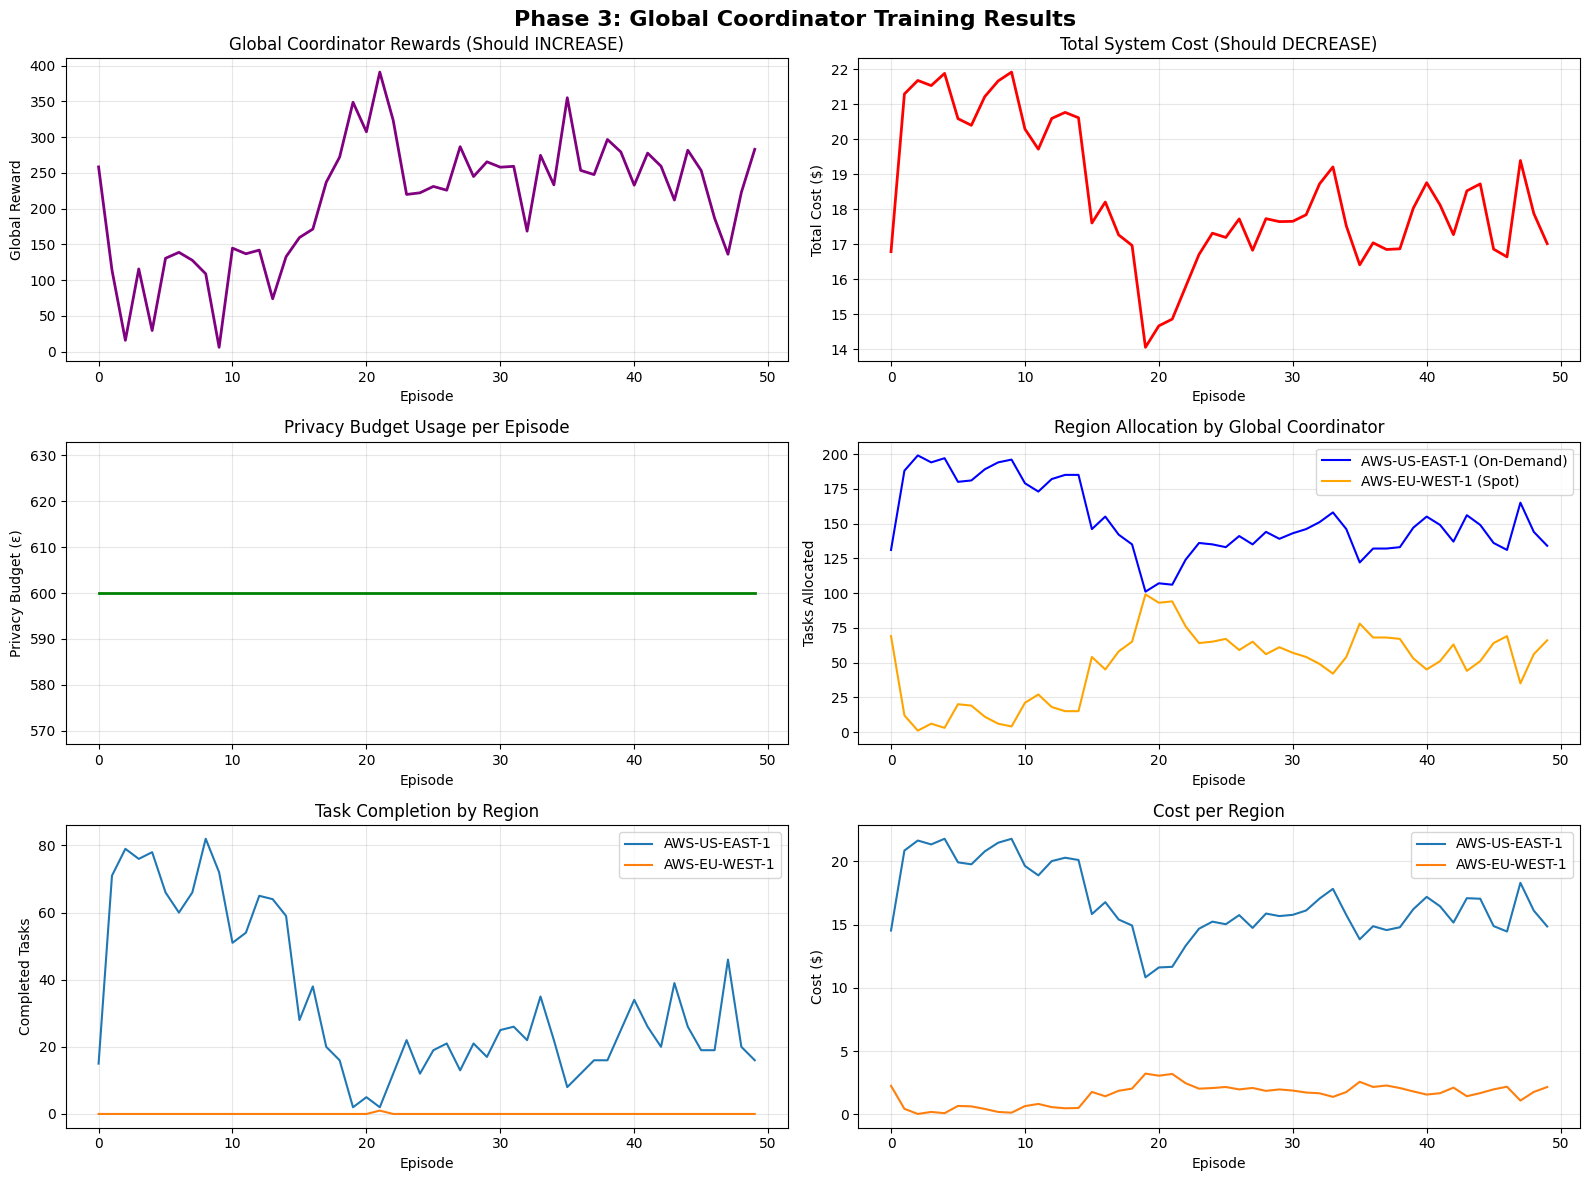

✅ Visualization saved


In [23]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Phase 3: Global Coordinator Training Results', fontsize=16, fontweight='bold')

# 1. Global Coordinator Rewards
axes[0, 0].plot(training_history['global']['episode_rewards'], color='purple', linewidth=2)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Global Reward')
axes[0, 0].set_title('Global Coordinator Rewards (Should INCREASE)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Total Costs
axes[0, 1].plot(training_history['global']['total_costs'], color='red', linewidth=2)
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Total Cost ($)')
axes[0, 1].set_title('Total System Cost (Should DECREASE)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Privacy Budget Usage
axes[1, 0].plot(training_history['global']['privacy_budget_used'], color='green', linewidth=2)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Privacy Budget (ε)')
axes[1, 0].set_title('Privacy Budget Usage per Episode')
axes[1, 0].grid(True, alpha=0.3)

# 4. Region Allocation Distribution
us_allocations = [alloc['AWS-US-EAST-1'] for alloc in training_history['global']['region_allocations']]
eu_allocations = [alloc['AWS-EU-WEST-1'] for alloc in training_history['global']['region_allocations']]
axes[1, 1].plot(us_allocations, label='AWS-US-EAST-1 (On-Demand)', color='blue')
axes[1, 1].plot(eu_allocations, label='AWS-EU-WEST-1 (Spot)', color='orange')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Tasks Allocated')
axes[1, 1].set_title('Region Allocation by Global Coordinator')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Completed Tasks per Region
for region_name in providers.keys():
    axes[2, 0].plot(training_history[region_name]['completed_tasks'], label=region_name)
axes[2, 0].set_xlabel('Episode')
axes[2, 0].set_ylabel('Completed Tasks')
axes[2, 0].set_title('Task Completion by Region')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6. Cost per Region
for region_name in providers.keys():
    axes[2, 1].plot(training_history[region_name]['episode_costs'], label=region_name)
axes[2, 1].set_xlabel('Episode')
axes[2, 1].set_ylabel('Cost ($)')
axes[2, 1].set_title('Cost per Region')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'phase3_aws/training_viz.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved")

## 13. Learning Analysis

In [24]:
print("="*60)
print("PHASE 3 LEARNING CURVE ANALYSIS")
print("="*60)

# Global Coordinator
gc_rewards = training_history['global']['episode_rewards']
gc_costs = training_history['global']['total_costs']

early_reward = np.mean(gc_rewards[:10])
late_reward = np.mean(gc_rewards[-10:])
early_cost = np.mean(gc_costs[:10])
late_cost = np.mean(gc_costs[-10:])

improvement = late_reward - early_reward
cost_reduction = early_cost - late_cost

print("\nGlobal Coordinator:")
print(f"  Reward: {early_reward:.2f} → {late_reward:.2f} ({improvement:+.2f})")
print(f"  Total Cost: ${early_cost:.2f} → ${late_cost:.2f} (${cost_reduction:+.2f})")

if improvement > 0 and cost_reduction > 0:
    print(f"  ✅ HIERARCHICAL LEARNING SUCCESSFUL!")
elif improvement > 0:
    print(f"  ⚠️ PARTIAL LEARNING (reward improved but not cost)")
else:
    print(f"  ❌ NO LEARNING DETECTED")

# Region allocation analysis
early_alloc = training_history['global']['region_allocations'][:10]
late_alloc = training_history['global']['region_allocations'][-10:]

early_eu_pct = np.mean([a['AWS-EU-WEST-1'] / (a['AWS-US-EAST-1'] + a['AWS-EU-WEST-1']) for a in early_alloc])
late_eu_pct = np.mean([a['AWS-EU-WEST-1'] / (a['AWS-US-EAST-1'] + a['AWS-EU-WEST-1']) for a in late_alloc])

print("\nRegion Allocation Learning:")
print(f"  EU-WEST-1 (Spot) usage: {early_eu_pct*100:.1f}% → {late_eu_pct*100:.1f}%")
if late_eu_pct > early_eu_pct:
    print(f"  ✅ Coordinator learned to prefer cheaper region!")
else:
    print(f"  ⚠️ Coordinator did not strongly prefer cheaper region")

# Privacy budget
avg_privacy_budget = np.mean(training_history['global']['privacy_budget_used'])
print(f"\nPrivacy Analysis:")
print(f"  Avg privacy budget per episode: ε={avg_privacy_budget:.2f}")
print(f"  Total privacy budget (composition): ε={avg_privacy_budget * NUM_EPISODES:.2f}")

print("\n" + "="*60)

PHASE 3 LEARNING CURVE ANALYSIS

Global Coordinator:
  Reward: 104.64 → 234.67 (+130.02)
  Total Cost: $20.89 → $17.92 ($+2.98)
  ✅ HIERARCHICAL LEARNING SUCCESSFUL!

Region Allocation Learning:
  EU-WEST-1 (Spot) usage: 7.5% → 27.2%
  ✅ Coordinator learned to prefer cheaper region!

Privacy Analysis:
  Avg privacy budget per episode: ε=600.00
  Total privacy budget (composition): ε=30000.00



## 14. Comparison: Phase 2 vs Phase 3

In [25]:
print("="*60)
print("PHASE 2 vs PHASE 3 COMPARISON")
print("="*60)

# Calculate Phase 2 total costs
phase2_us_cost = np.mean(phase2_history['AWS-US-EAST-1']['episode_costs'])
phase2_eu_cost = np.mean(phase2_history['AWS-EU-WEST-1']['episode_costs'])
phase2_total_cost = phase2_us_cost + phase2_eu_cost

# Calculate Phase 3 total cost
phase3_total_cost = np.mean(training_history['global']['total_costs'])

# Calculate Phase 2 total rewards
phase2_us_reward = np.mean(phase2_history['AWS-US-EAST-1']['episode_rewards'])
phase2_eu_reward = np.mean(phase2_history['AWS-EU-WEST-1']['episode_rewards'])
phase2_total_reward = phase2_us_reward + phase2_eu_reward

# Phase 3 total reward
phase3_total_reward = np.mean(training_history['global']['episode_rewards'])

print("\nCost Comparison:")
print(f"  Phase 2 (Independent Agents): ${phase2_total_cost:.2f}")
print(f"  Phase 3 (Global Coordinator): ${phase3_total_cost:.2f}")
cost_improvement = ((phase2_total_cost - phase3_total_cost) / phase2_total_cost) * 100
print(f"  Improvement: {cost_improvement:+.2f}%")

print("\nReward Comparison:")
print(f"  Phase 2 (Independent Agents): {phase2_total_reward:.2f}")
print(f"  Phase 3 (Global Coordinator): {phase3_total_reward:.2f}")
reward_improvement = phase3_total_reward - phase2_total_reward
print(f"  Improvement: {reward_improvement:+.2f}")

print("\n" + "="*60)
print("PHASE 3 IMPLEMENTATION COMPLETE!")
print("="*60)
print("\n✅ Global Coordinator trained with hierarchical RL")
print("✅ Task segmentation integrated (K-means)")
print("✅ Differential privacy applied to communication")
print("✅ Multi-region coordination (US-EAST-1 + EU-WEST-1)")
print("\nNext: Deploy to real AWS infrastructure and evaluate!")

PHASE 2 vs PHASE 3 COMPARISON

Cost Comparison:
  Phase 2 (Independent Agents): $28.57
  Phase 3 (Global Coordinator): $18.34
  Improvement: +35.83%

Reward Comparison:
  Phase 2 (Independent Agents): -1422.93
  Phase 3 (Global Coordinator): 211.18
  Improvement: +1634.12

PHASE 3 IMPLEMENTATION COMPLETE!

✅ Global Coordinator trained with hierarchical RL
✅ Task segmentation integrated (K-means)
✅ Differential privacy applied to communication
✅ Multi-region coordination (US-EAST-1 + EU-WEST-1)

Next: Deploy to real AWS infrastructure and evaluate!
